In [9]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# data_standardized = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Standardized_data/standardized_features_tech.parquet"
data = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/total_dataset_tech.parquet"
total_train = pd.read_parquet(data)
total_train = total_train[total_train['date'] < '2021-01-01']
total_train['tau'] = total_train['lag_trading_days'] / 252

# train = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Standardized_data/train_data_tech.parquet"
# validation = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Standardized_data/validate_data_tech.parquet"

# # Write the DataFrame to a CSV file
# train = pd.read_parquet(train)
# validation = pd.read_parquet(validation)
# total_train = pd.concat([train, validation])

# total_train = total_train.reset_index()

In [10]:
total_train

,cp_flag,m_category,maturity_group,Ticker,date,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,...,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2,tau
2,C,m<-0.5,τ≤5,AAPL,2019-01-02,0.517976,0.388720,4965.000000,9246.000000,2.000000,...,6.0,0.027847,2.548018e-12,0.040515,0.027893,0.344719,3.369334,1.040351e-08,36.0,0.003968
3,P,m<-0.5,τ≤5,AAPL,2019-01-02,0.506737,0.345317,4814.428571,2574.428571,2.000000,...,6.0,0.027847,2.548018e-12,0.040515,0.027893,0.344719,3.369334,1.040351e-08,36.0,0.003968
4,C,m<-0.5,τ≤5,AAPL,2019-01-03,0.774712,0.472727,2924.000000,2819.750000,1.000000,...,6.0,0.028037,2.557111e-12,0.041546,0.027900,0.341555,3.361944,1.046380e-08,36.0,0.000000
5,P,m<-0.5,τ≤5,AAPL,2019-01-03,0.659214,0.813854,6538.666667,4091.833333,1.000000,...,6.0,0.028037,2.557111e-12,0.041546,0.027900,0.341555,3.361944,1.046380e-08,36.0,0.000000
6,C,m<-0.5,τ≤5,AAPL,2019-01-04,0.373498,0.000000,265.625000,45.875000,5.000000,...,6.0,0.028228,2.566203e-12,0.042578,0.027907,0.338390,3.354553,1.052410e-08,36.0,0.015873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112307,P,|m|≤0.5,τ>60,TSLA,2020-12-29,0.646990,0.646823,20.580645,211.677419,144.769231,...,4.0,0.047195,1.793477e-12,0.098269,0.038656,0.515624,17.690173,2.629202e-09,37.0,0.570513
112308,C,|m|≤0.5,τ>60,TSLA,2020-12-30,0.660231,0.664992,27.774194,2415.096774,147.236842,...,4.0,0.047563,1.806918e-12,0.100119,0.038964,0.523628,17.900318,2.641832e-09,37.0,0.580305
112309,P,|m|≤0.5,τ>60,TSLA,2020-12-30,0.660325,0.659732,22.519231,237.019231,144.545455,...,4.0,0.047563,1.806918e-12,0.100119,0.038964,0.523628,17.900318,2.641832e-09,37.0,0.569625
112310,C,|m|≤0.5,τ>60,TSLA,2020-12-31,0.681320,0.686164,137.000000,1991.105263,146.225000,...,4.0,0.047931,1.820359e-12,0.101968,0.039271,0.531632,18.110463,2.654462e-09,37.0,0.576290


In [11]:
# Create filter for only short maturity (τ≤5)
total_train = total_train[total_train["maturity_group"] == "τ≤5"]

total_train = total_train[total_train['Ticker'] == 'AAPL']
total_train = total_train[total_train['m_category'] == '|m|≤0.5']


In [12]:
if 'moneyness' in total_train.columns:
    print("Column 'moneyness' exists in the DataFrame.")
else:
    print("Column 'moneyness' does not exist in the DataFrame.")

Column 'moneyness' exists in the DataFrame.


In [13]:
total_train

,cp_flag,m_category,maturity_group,Ticker,date,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,...,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2,tau
75602,C,|m|≤0.5,τ≤5,AAPL,2019-01-02,0.347693,0.344962,17225.000000,12190.000000,2.0,...,6.0,0.027847,2.548018e-12,0.040515,0.027893,0.344719,3.369334,1.040351e-08,36.0,0.003968
75603,P,|m|≤0.5,τ≤5,AAPL,2019-01-02,0.429584,0.347693,8854.000000,3901.500000,2.0,...,6.0,0.027847,2.548018e-12,0.040515,0.027893,0.344719,3.369334,1.040351e-08,36.0,0.003968
75604,C,|m|≤0.5,τ≤5,AAPL,2019-01-03,0.560617,0.408192,18730.500000,13824.000000,1.0,...,6.0,0.028037,2.557111e-12,0.041546,0.027900,0.341555,3.361944,1.046380e-08,36.0,0.000000
75605,P,|m|≤0.5,τ≤5,AAPL,2019-01-03,0.520007,0.560617,8632.000000,5685.500000,1.0,...,6.0,0.028037,2.557111e-12,0.041546,0.027900,0.341555,3.361944,1.046380e-08,36.0,0.000000
75606,C,|m|≤0.5,τ≤5,AAPL,2019-01-04,0.332546,0.000000,9629.600000,109.400000,5.0,...,6.0,0.028228,2.566203e-12,0.042578,0.027907,0.338390,3.354553,1.052410e-08,36.0,0.015873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76607,P,|m|≤0.5,τ≤5,AAPL,2020-12-29,0.352450,0.337237,21562.500000,1272.500000,2.0,...,6.0,0.024241,1.047530e-12,0.042300,0.018422,0.313858,1.910815,1.716682e-08,36.0,0.003968
76608,C,|m|≤0.5,τ≤5,AAPL,2020-12-30,0.312952,0.379564,45992.000000,25123.000000,1.0,...,6.0,0.024084,1.040019e-12,0.041568,0.018102,0.313600,1.880373,1.735622e-08,36.0,0.000000
76609,P,|m|≤0.5,τ≤5,AAPL,2020-12-30,0.273113,0.312952,35001.750000,10098.250000,1.0,...,6.0,0.024084,1.040019e-12,0.041568,0.018102,0.313600,1.880373,1.735622e-08,36.0,0.000000
76610,C,|m|≤0.5,τ≤5,AAPL,2020-12-31,0.331319,0.000000,80840.666667,20647.333333,5.0,...,6.0,0.023927,1.032508e-12,0.040837,0.017781,0.313343,1.849931,1.754562e-08,36.0,0.015873


# Create the additional collumns and add select only the specific

In [14]:
# Select the relevant columns
selected_columns = ['m_category', 'maturity_group', 'Ticker', 'date', 'cp_flag', 'impl_volatility', 'moneyness', 'tau']
total_train_new = total_train[selected_columns]

total_train_new['moneyness_squared'] = total_train_new['moneyness'] ** 2
total_train_new['moneyness_tau'] = total_train_new['moneyness'] * total_train_new['tau']

calls_data = total_train_new[total_train_new['cp_flag'] == 'C']
puts_data = total_train_new[total_train_new['cp_flag'] == 'P']

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_92553/3854728843.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_train_new['moneyness_squared'] = total_train_new['moneyness'] ** 2
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_92553/3854728843.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_train_new['moneyness_tau'] = total_train_new['moneyness'] * total_train_new['tau']


In [15]:
puts_data_all = total_train[total_train['cp_flag'] == 'P']
puts_data_all

,cp_flag,m_category,maturity_group,Ticker,date,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,...,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2,tau
75603,P,|m|≤0.5,τ≤5,AAPL,2019-01-02,0.429584,0.347693,8854.000000,3901.500000,2.0,...,6.0,0.027847,2.548018e-12,0.040515,0.027893,0.344719,3.369334,1.040351e-08,36.0,0.003968
75605,P,|m|≤0.5,τ≤5,AAPL,2019-01-03,0.520007,0.560617,8632.000000,5685.500000,1.0,...,6.0,0.028037,2.557111e-12,0.041546,0.027900,0.341555,3.361944,1.046380e-08,36.0,0.000000
75607,P,|m|≤0.5,τ≤5,AAPL,2019-01-04,0.334004,0.332546,18138.400000,1839.600000,5.0,...,6.0,0.028228,2.566203e-12,0.042578,0.027907,0.338390,3.354553,1.052410e-08,36.0,0.015873
75609,P,|m|≤0.5,τ≤5,AAPL,2019-01-07,0.377959,0.377680,3847.666667,931.333333,4.0,...,6.0,0.028801,2.593480e-12,0.045671,0.027927,0.328897,3.332380,1.070499e-08,36.0,0.011905
75611,P,|m|≤0.5,τ≤5,AAPL,2019-01-08,0.374078,0.360177,7189.666667,1929.833333,3.0,...,6.0,0.028991,2.602572e-12,0.046703,0.027934,0.325733,3.324990,1.076528e-08,36.0,0.007937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76603,P,|m|≤0.5,τ≤5,AAPL,2020-12-24,0.274780,0.282278,16637.000000,6439.250000,4.0,...,6.0,0.025026,1.085085e-12,0.045959,0.020022,0.315145,2.063025,1.621982e-08,36.0,0.011905
76605,P,|m|≤0.5,τ≤5,AAPL,2020-12-28,0.346353,0.366171,10290.000000,4826.800000,3.0,...,6.0,0.024398,1.055041e-12,0.043032,0.018742,0.314115,1.941257,1.697742e-08,36.0,0.007937
76607,P,|m|≤0.5,τ≤5,AAPL,2020-12-29,0.352450,0.337237,21562.500000,1272.500000,2.0,...,6.0,0.024241,1.047530e-12,0.042300,0.018422,0.313858,1.910815,1.716682e-08,36.0,0.003968
76609,P,|m|≤0.5,τ≤5,AAPL,2020-12-30,0.273113,0.312952,35001.750000,10098.250000,1.0,...,6.0,0.024084,1.040019e-12,0.041568,0.018102,0.313600,1.880373,1.735622e-08,36.0,0.000000


In [16]:
def ols(data):
    y = data['impl_volatility']
    X = data.drop(columns=['date', 'm_category', 'maturity_group', 'Ticker', 'cp_flag', 'impl_volatility'])
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model

ols_puts = ols(puts_data_all)
print("AHBS Model Summary for Puts (cp_flag = 'P'):")
print(ols_puts.summary())



AHBS Model Summary for Puts (cp_flag = 'P'):
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     191.7
Date:                Thu, 25 Jul 2024   Prob (F-statistic):          3.10e-266
Time:                        16:08:43   Log-Likelihood:                 901.88
No. Observations:                 501   AIC:                            -1712.
Df Residuals:                     455   BIC:                            -1518.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [17]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# # Select the relevant columns
# selected_columns = ['m_category', 'maturity_group', 'Ticker', 'date', 'cp_flag', 'impl_volatility', 'moneyness', 'tau']
# total_train = total_train[selected_columns]

# # Function to prepare data
# def prepare_data(data):
#     data = data.copy()  # Ensure we are working with a copy
#     data['moneyness_squared'] = data['moneyness'] ** 2
#     data['moneyness_tau'] = data['moneyness'] * data['tau']
#     return data

# Function to fit AHBS model
def adhbs_model(data):
    X = data[['moneyness', 'moneyness_squared', 'tau', 'moneyness_tau']]
    X = sm.add_constant(X)
    y = data['impl_volatility']
    model = sm.OLS(y, X).fit()
    return model

# # Filter data for calls (cp_flag = 'C') and puts (cp_flag = 'P')
# calls_data = total_train[total_train['cp_flag'] == 'C']
# puts_data = total_train[total_train['cp_flag'] == 'P']

# # Prepare data for calls and puts
# calls_data_prepared = prepare_data(calls_data)
# puts_data_prepared = prepare_data(puts_data)

# Fit the AHBS model for calls
adhbs_model_calls = adhbs_model(calls_data)
print("AHBS Model Summary for Calls (cp_flag = 'C'):")
print(adhbs_model_calls.summary())

# Fit the AHBS model for puts
adhbs_model_puts = adhbs_model(puts_data)
print("AHBS Model Summary for Puts (cp_flag = 'P'):")
print(adhbs_model_puts.summary())


AHBS Model Summary for Calls (cp_flag = 'C'):
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     7.362
Date:                Thu, 25 Jul 2024   Prob (F-statistic):           9.15e-06
Time:                        16:08:43   Log-Likelihood:                 157.48
No. Observations:                 501   AIC:                            -305.0
Df Residuals:                     496   BIC:                            -283.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

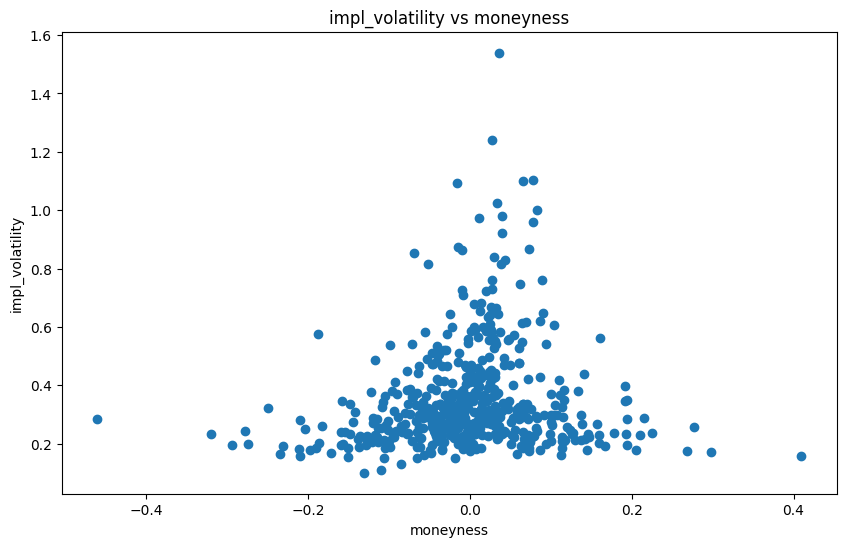

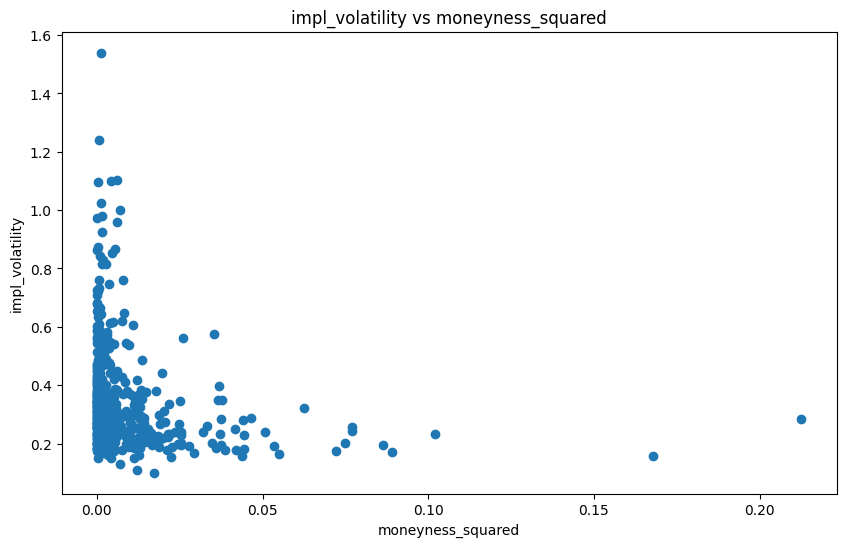

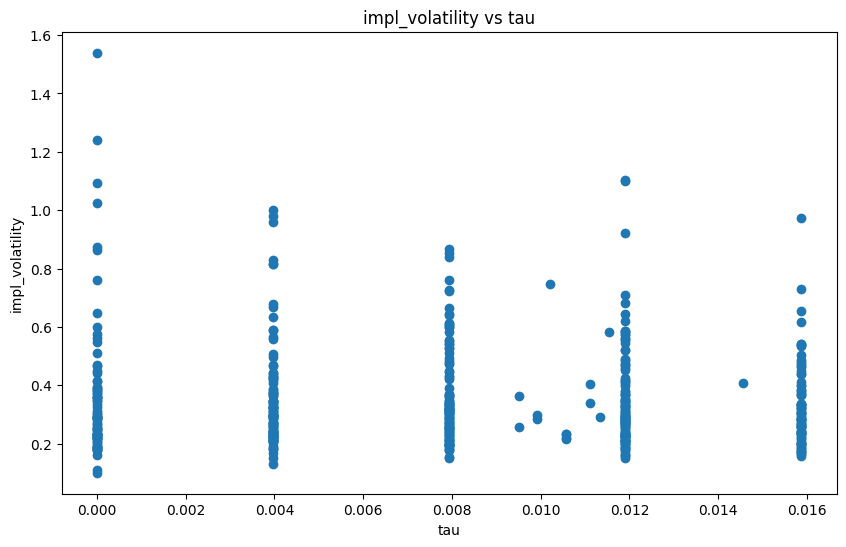

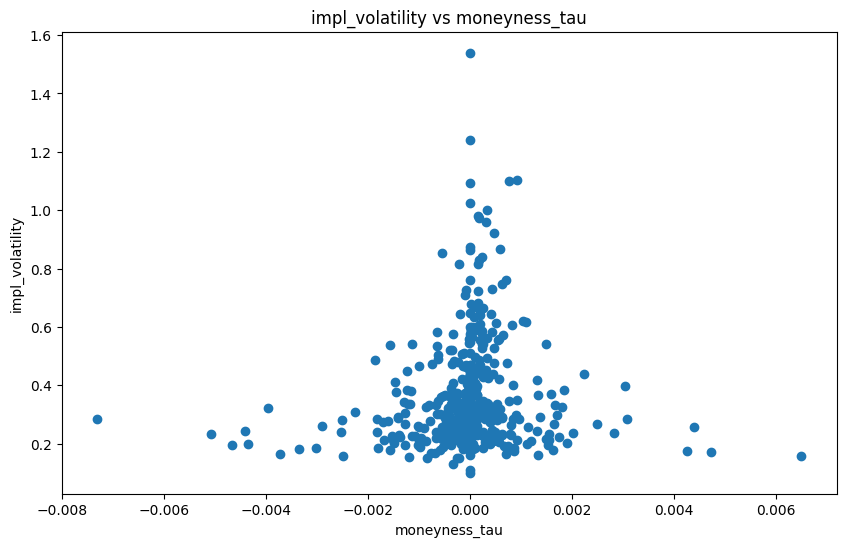

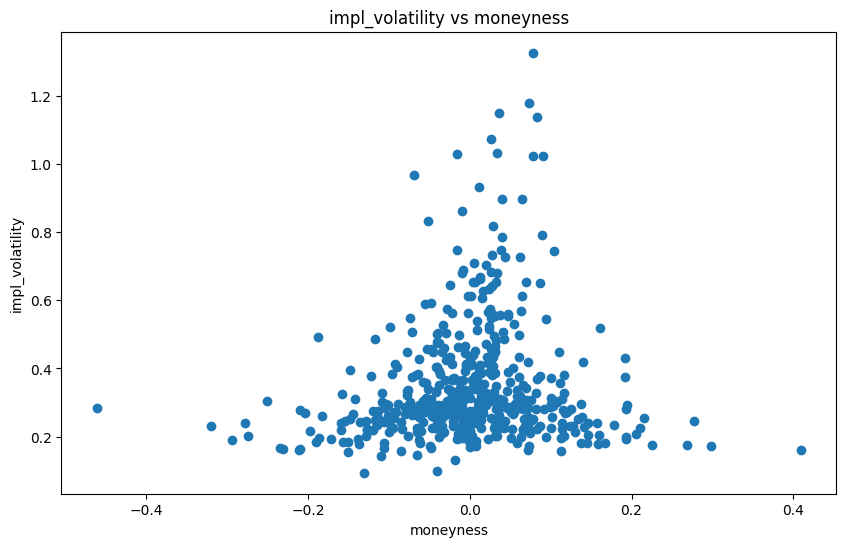

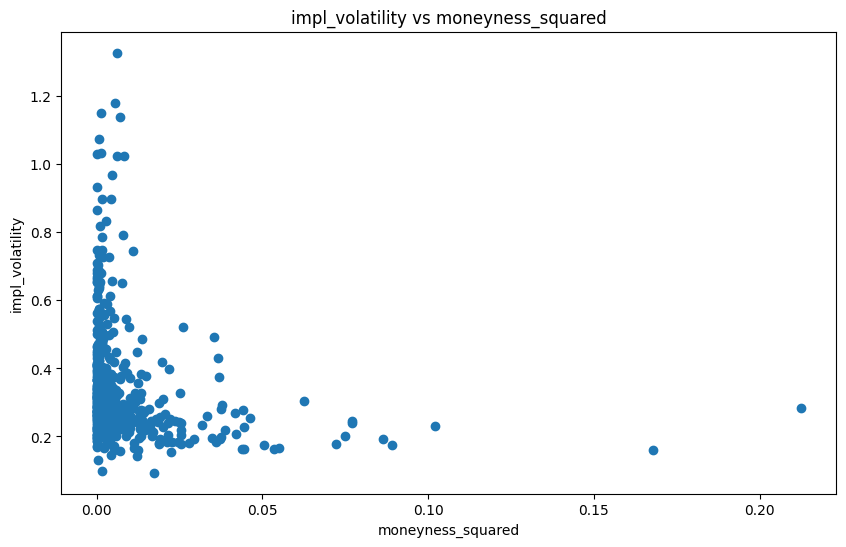

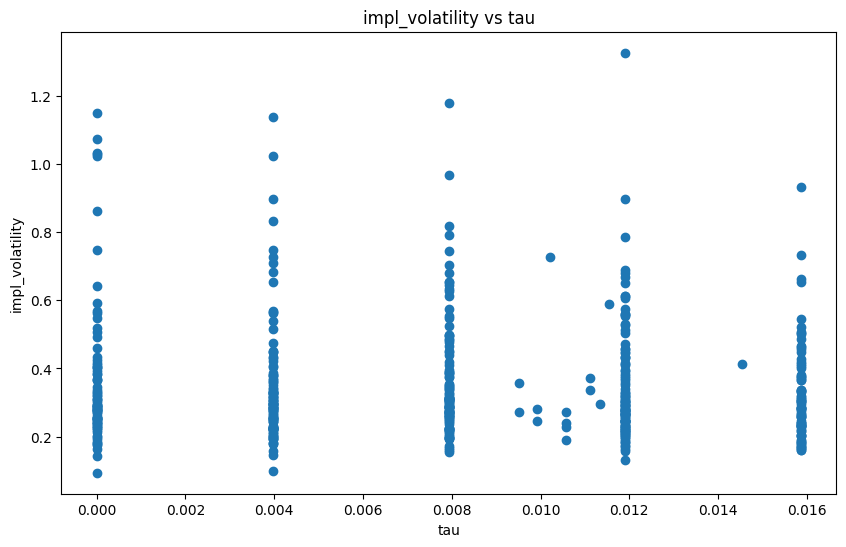

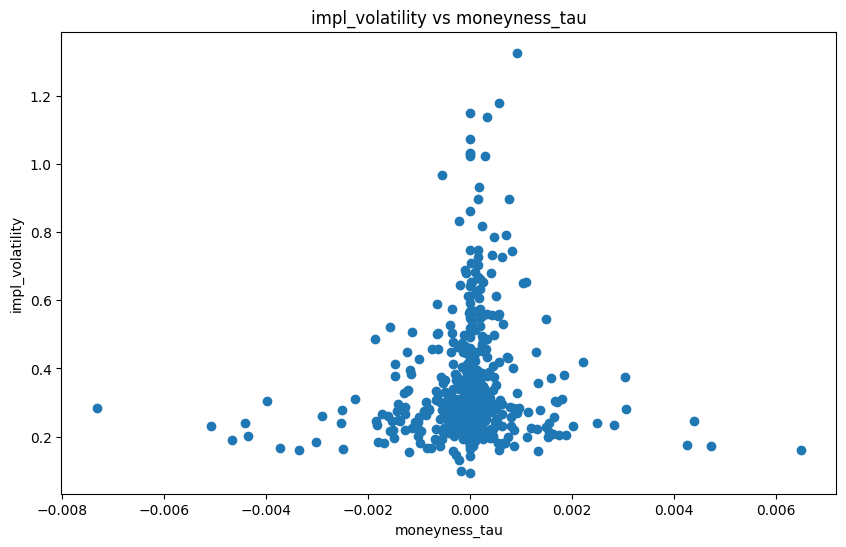

In [18]:
import matplotlib.pyplot as plt

# Function to plot data
def plot_data(data, x_columns, y_column):
    for x_column in x_columns:
        plt.figure(figsize=(10, 6))
        plt.scatter(data[x_column], data[y_column])
        plt.xlabel(x_column)
        plt.ylabel(y_column)
        plt.title(f'{y_column} vs {x_column}')
        plt.show()

# Plot data for calls
plot_data(calls_data, ['moneyness', 'moneyness_squared', 'tau', 'moneyness_tau'], 'impl_volatility')

# Plot data for puts
plot_data(puts_data, ['moneyness', 'moneyness_squared', 'tau', 'moneyness_tau'], 'impl_volatility')

In [19]:
coefficients = adhns_model.params
coefficients

for coef in coefficients:
    print(coef)

NameError: name 'adhns_model' is not defined

## The model used is a linear regression model

In [ ]:

# Function to create rolling window data
def create_rolling_window(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df['impl_volatility'].iloc[i:i+window_size].values)
        y.append(df['impl_volatility'].iloc[i+window_size])
    return np.array(X), np.array(y)

# Create a DataFrame to store the results
results = pd.DataFrame(columns=['Ticker', 'RMSE LR', 'OoR^2 LR'])

# Get unique tickers
tickers = df_standardized['Ticker'].unique()

# Create a separate model for each ticker
for ticker in tickers:
    # Select the rows for the current ticker
    df_ticker = df_standardized[df_standardized['Ticker'] == ticker]

    # Split the data into training and testing sets
    train_data = df_ticker[df_ticker['date'].dt.year < 2021]
    test_data = df_ticker[df_ticker['date'].dt.year == 2021]

    # Create rolling window data with a window size of 4
    window_size = 4
    X_train, y_train = create_rolling_window(train_data, window_size)
    X_test, y_test = create_rolling_window(test_data, window_size)
    # Train a simple model (e.g., Linear Regression) for demonstration
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    
    
    # # Calculate the RMSE
    # mse = mean_squared_error(y_test, y_pred)
    # rmse = np.sqrt(mse)
    # # rmse = calculate_daily_rmse(df)
    # # Calculate the out-of-sample R^2
    # ooR2 = calculate_oos_r2(y_test, y_pred)

    # # Store the results
    # results = pd.concat([results, pd.DataFrame([{'Ticker': ticker, 'RMSE LR': rmse, 'OoR^2 LR': ooR2}])], ignore_index=True)

# Print the results
results

NameError: name 'df_standardized' is not defined

In [ ]:
y_pred

array([0.85692403, 0.89132258, 0.76376255, 0.92145783, 0.91061644,
       0.9848082 , 1.33380571, 0.54650318, 0.29861346, 0.6983638 ,
       0.50594143, 0.49336806, 0.57783631, 0.54875991, 0.5078436 ,
       0.46291973, 0.78292898, 0.72015584, 0.3465823 , 0.32733927,
       0.4567762 , 0.44176653, 0.38275241, 0.48798392, 0.43980205,
       0.36272947, 0.39945084, 0.36322119, 0.35424787, 0.42432149,
       0.40391424])

## Adhoc-BS model

In [ ]:
# Function to prepare the data for the AHBS model
df = data

def prepare_ahbs_data(df):
    df['moneyness_squared'] = df['moneyness'] ** 2
    df['moneyness_times_ttm'] = df['moneyness'] * df['T']
    X = df[['moneyness', 'moneyness_squared', 'T', 'moneyness_times_ttm']]
    y = df['impl_volatility']
    return X, y

# Create a DataFrame to store the results
results = pd.DataFrame(columns=['Ticker', 'RMSE', 'ooR2'])

# Create a separate model for each ticker
for ticker in tickers:
    # Select the rows for the current ticker
    df_ticker = df_standardized[df_standardized['Ticker'] == ticker]

    # Split the data into training and testing sets
    train_data = df_ticker[df_ticker['date'].dt.year < 2021]
    test_data = df_ticker[df_ticker['date'].dt.year == 2021]

    # Prepare the data for the AHBS model
    X_train, y_train = prepare_ahbs_data(train_data)
    X_test, y_test = prepare_ahbs_data(test_data)

    # Train the AHBS model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate the RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Calculate the out-of-sample R^2
    ooR2 = calculate_oos_r2(y_test, y_pred)

    # Store the results
    results = pd.concat([results, pd.DataFrame([{'Ticker': ticker, 'RMSE': rmse, 'ooR2': ooR2}])], ignore_index=True)

    # # Plot the predictions vs actual values
    # plt.figure(figsize=(10, 6))
    # plt.plot(test_data['date'], y_test, label='Actual Values')
    # plt.plot(test_data['date'], y_pred, label='Predicted Values')
    # plt.xlabel('Date')
    # plt.ylabel('Implied Volatility')
    # plt.title(f'Predicted vs Actual Implied Volatility for {ticker} in 2021')
    # plt.legend()
    # plt.show()



# Print the results
print(results)

# Store the results
results_row = {'Ticker': ticker, 'RMSE': rmse, 'ooR2': ooR2}
if ticker in results['Ticker'].values:
    results.loc[results['Ticker'] == ticker, ['RMSE', 'ooR2']] = [rmse, ooR2]
else:
    results = results.append(results_row, ignore_index=True)

results

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_97337/3416344774.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['moneyness_squared'] = df['moneyness'] ** 2
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_97337/3416344774.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['moneyness_times_ttm'] = df['moneyness'] * df['T']
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_97337/3416344774.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

  Ticker      RMSE  ooR2
0   AMZN  0.264007  -inf
1   BKNG  0.228161  -inf
2   META  0.255573  -inf
3    WMT  0.374206  -inf
4   EXPE  0.483756  -inf
5   MSFT  0.712202  -inf
6   TSLA  0.523718  -inf
7   NVDA  0.415542  -inf
8   COST  0.289000  -inf
9   COHR  0.947592  -inf


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_97337/3416344774.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['moneyness_squared'] = df['moneyness'] ** 2
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_97337/3416344774.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['moneyness_times_ttm'] = df['moneyness'] * df['T']
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_97337/3416344774.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

,Ticker,RMSE,ooR2
0,AMZN,0.264007,-inf
1,BKNG,0.228161,-inf
2,META,0.255573,-inf
3,WMT,0.374206,-inf
4,EXPE,0.483756,-inf
5,MSFT,0.712202,-inf
6,TSLA,0.523718,-inf
7,NVDA,0.415542,-inf
8,COST,0.289000,-inf
9,COHR,0.947592,-inf


Mean Squared Error for AMZN in 2021: 0.0010128778085938563


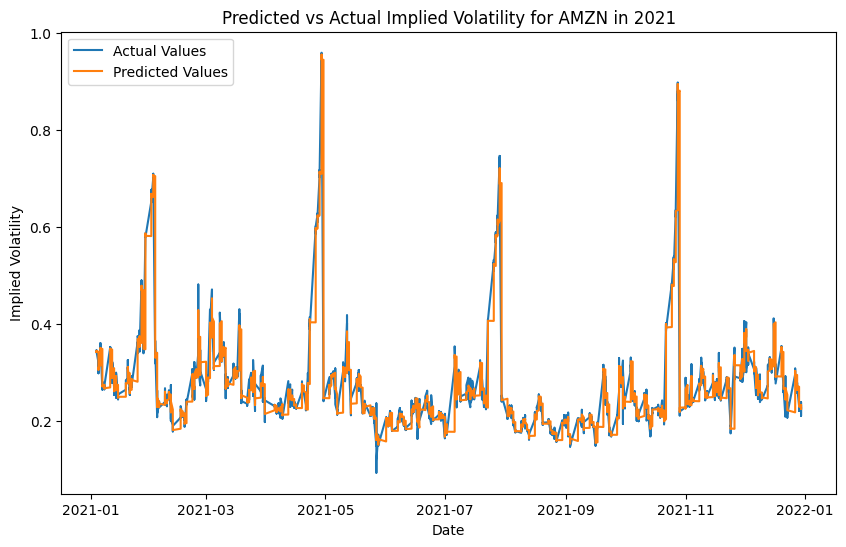

Mean Squared Error for BKNG in 2021: 0.0011607025368343274


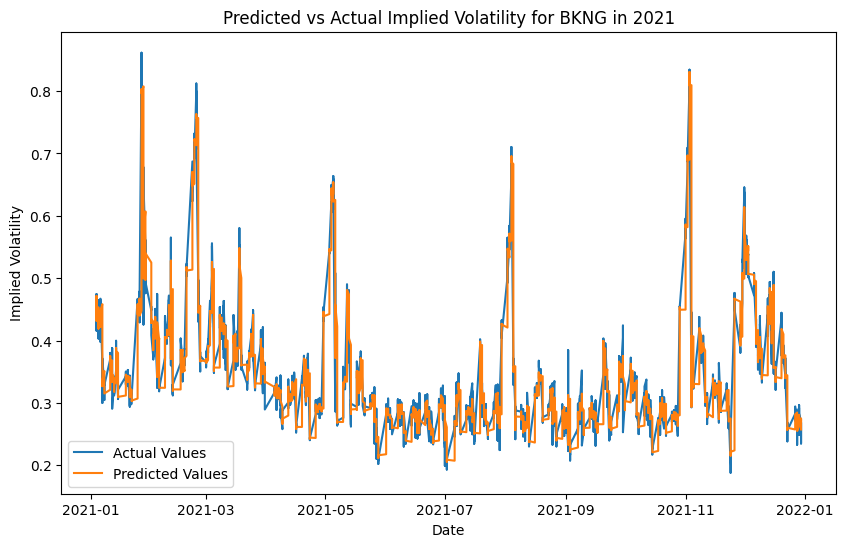

Mean Squared Error for META in 2021: 0.0041654013793880305


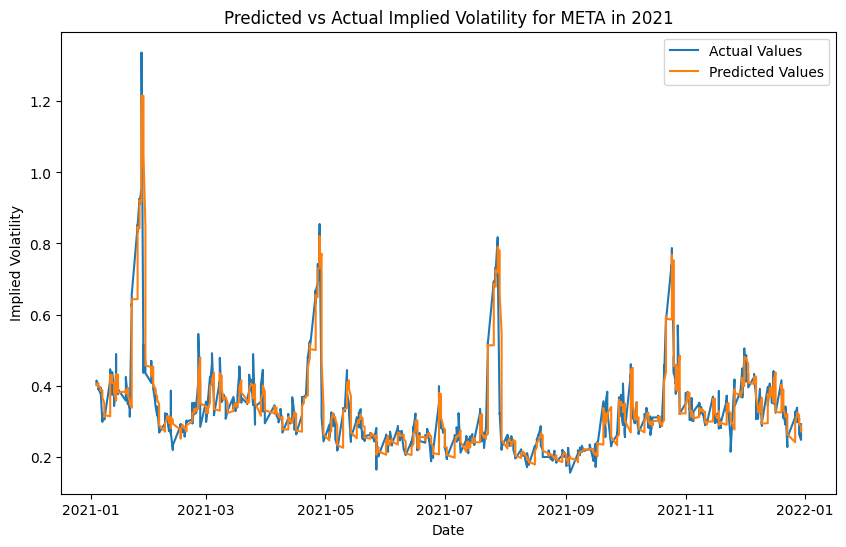

Mean Squared Error for WMT in 2021: 0.0019325550689523524


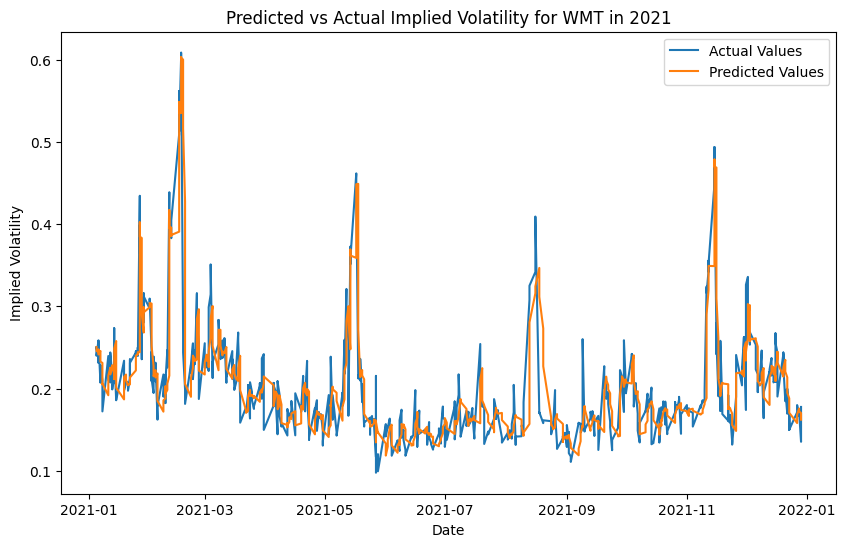

Mean Squared Error for EXPE in 2021: 0.019978609492801273


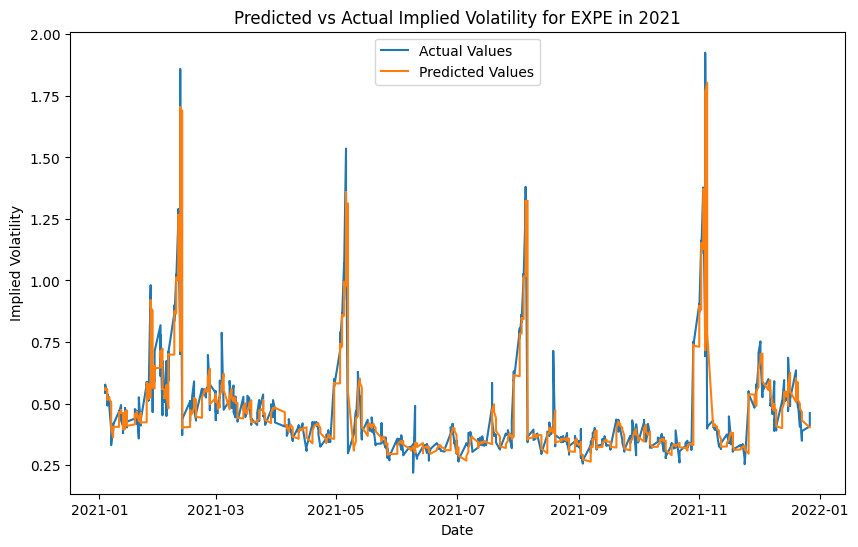

Mean Squared Error for MSFT in 2021: 0.002079382827941805


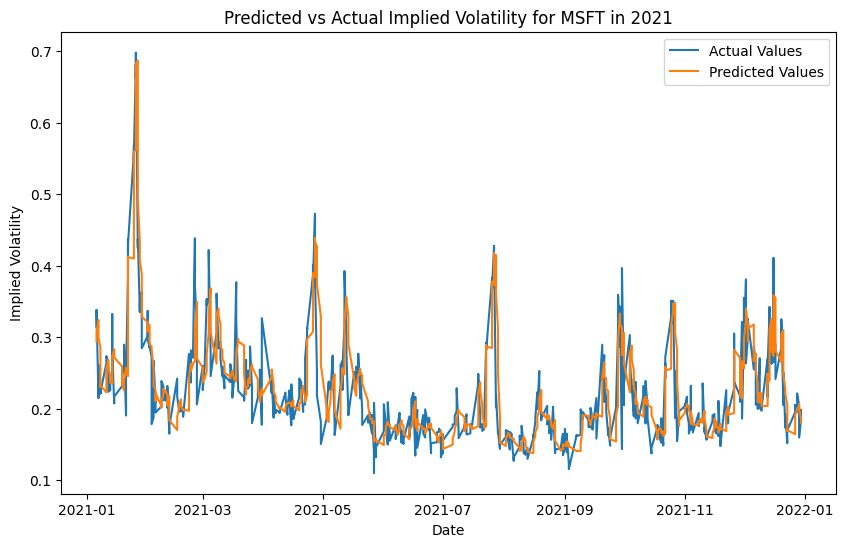

Mean Squared Error for TSLA in 2021: 0.002765704632912524


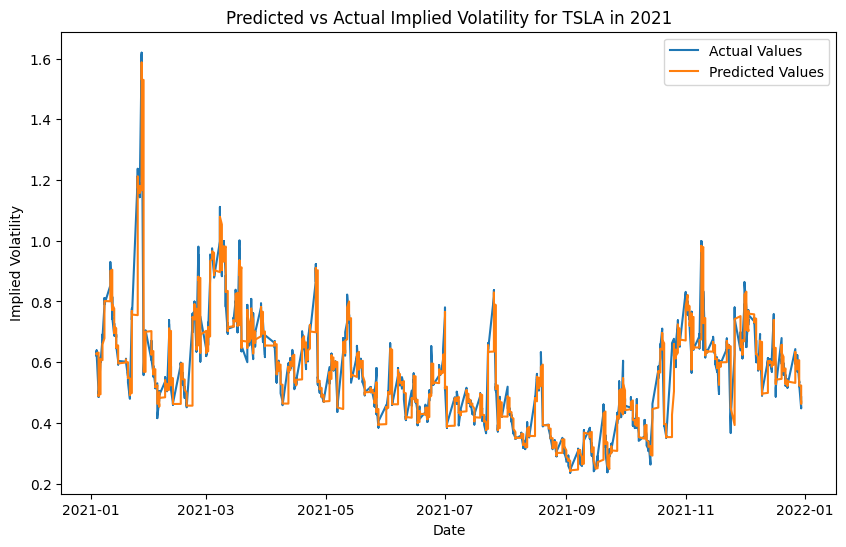

Mean Squared Error for NVDA in 2021: 0.003331479054872507


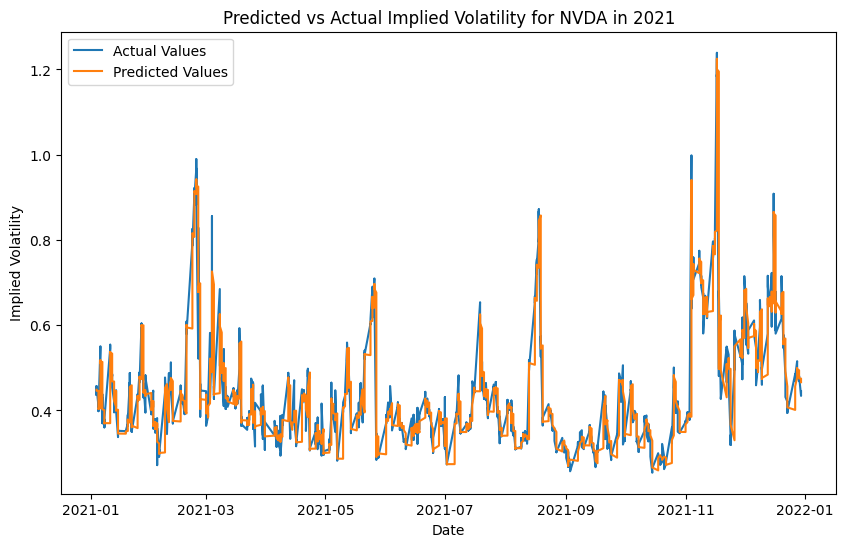

Mean Squared Error for COST in 2021: 0.0028907102072302745


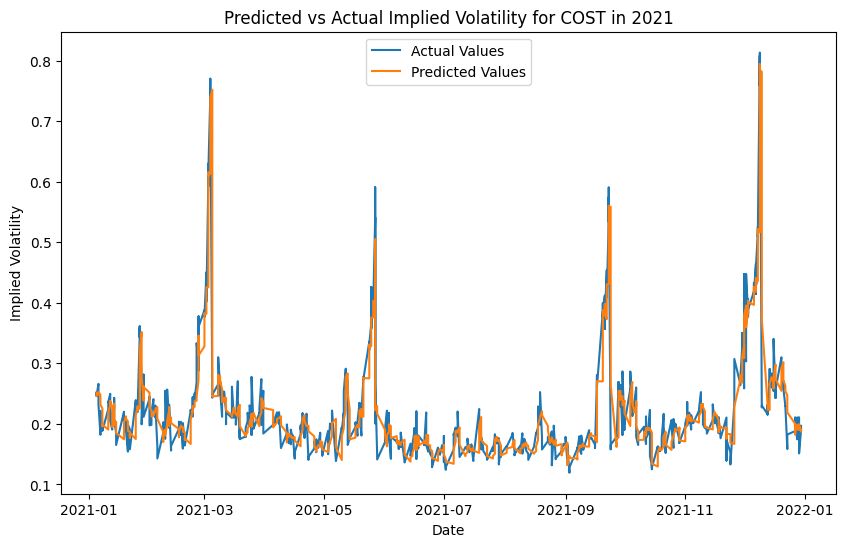

Mean Squared Error for COHR in 2021: 0.05028159832643952


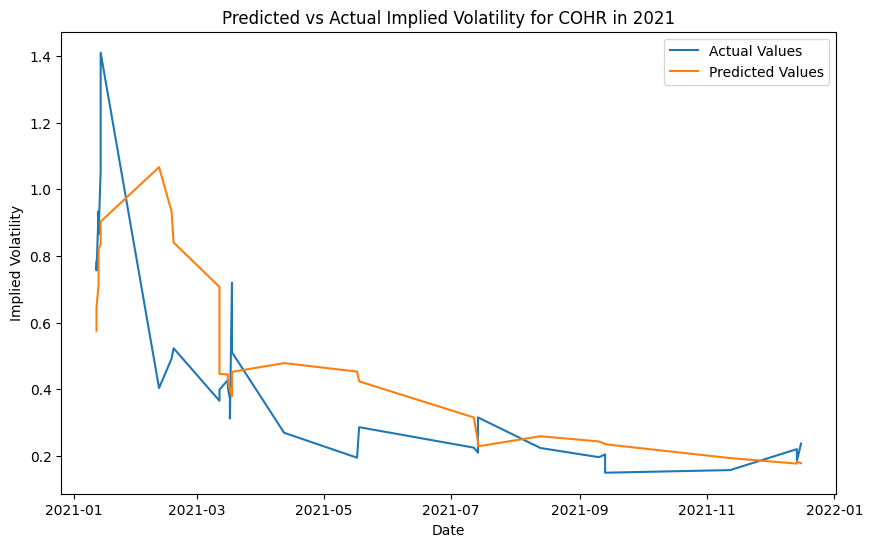

In [ ]:
# Get unique tickers
df = df_standardized 

tickers = df['Ticker'].unique()

# Function to create rolling window data
def create_rolling_window(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df['impl_volatility'].iloc[i:i+window_size].values)
        y.append(df['impl_volatility'].iloc[i+window_size])
    return np.array(X), np.array(y)

for ticker in tickers:
    # Select the rows for the current ticker
    df_ticker = df[df['Ticker'] == ticker]

    # Split the data into training and testing sets
    train_data = df_ticker[df_ticker['date'].dt.year < 2021]
    test_data = df_ticker[df_ticker['date'].dt.year == 2021]

    # Create rolling window data with a window size of 4
    window_size = 4
    X_train, y_train = create_rolling_window(train_data, window_size)
    X_test, y_test = create_rolling_window(test_data, window_size)

    # Implementing a simple ad-hoc BS model for demonstration
    def ad_hoc_bs_model(X):
        # For simplicity, we take the mean of implied volatilities as our prediction
        # This is a placeholder for a more sophisticated model
        return X.mean(axis=1)

    # Predict on the test set using ad-hoc BS model
    y_pred = ad_hoc_bs_model(X_test)

    # Calculate the Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error for {ticker} in 2021: {mse}")

    # Plot the predictions vs actual values
    plt.figure(figsize=(10, 6))
    plt.plot(test_data['date'][window_size:], y_test, label='Actual Values')
    plt.plot(test_data['date'][window_size:], y_pred, label='Predicted Values')
    plt.xlabel('Date')
    plt.ylabel('Implied Volatility')
    plt.title(f'Predicted vs Actual Implied Volatility for {ticker} in 2021')
    plt.legend()
    plt.show()

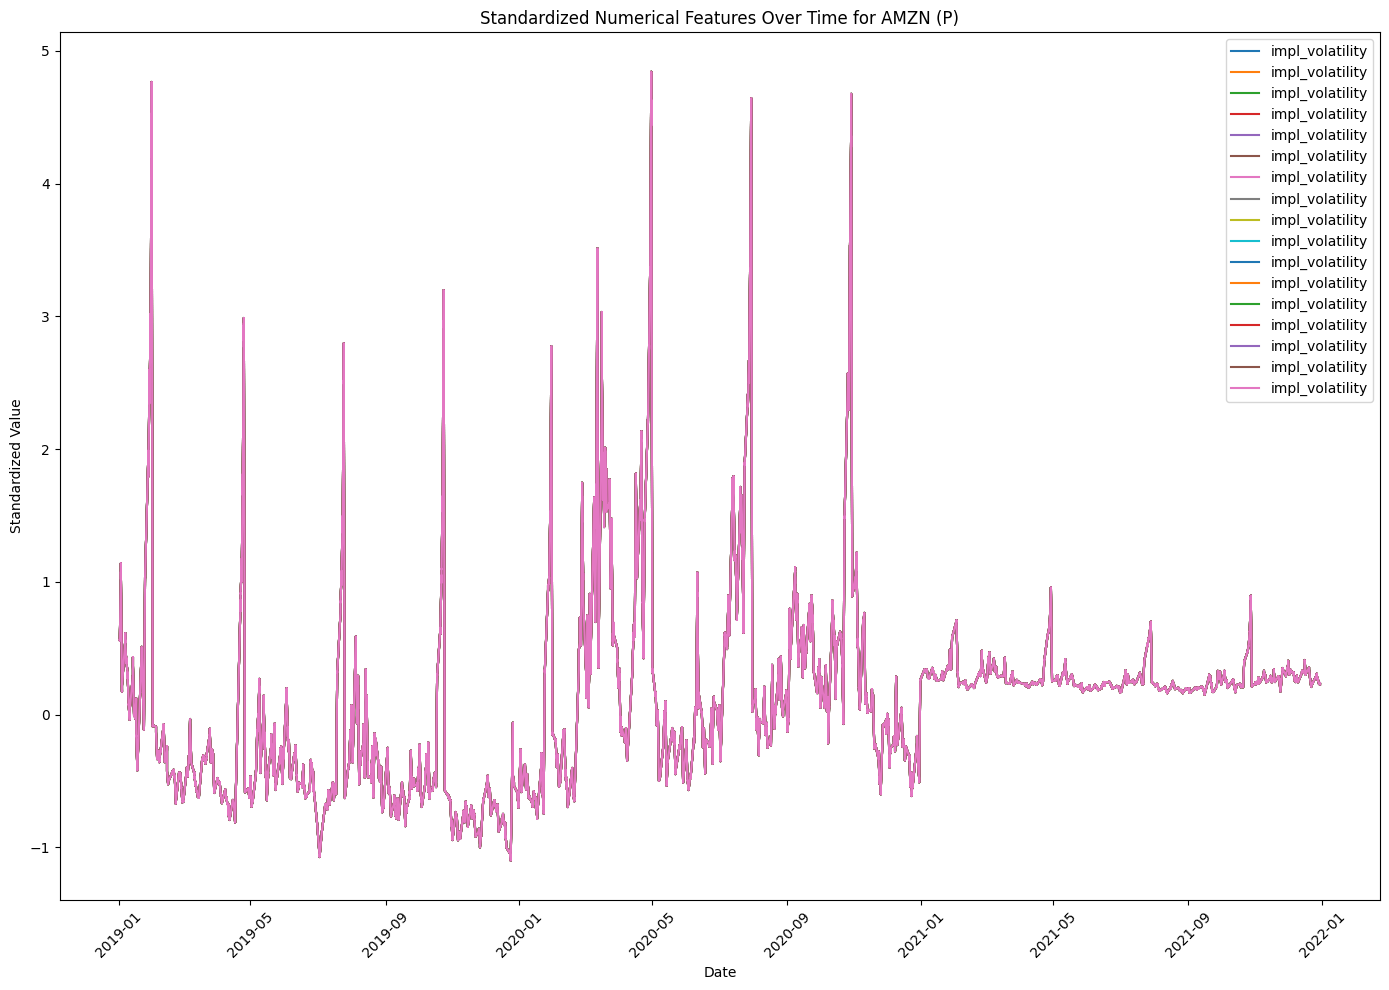

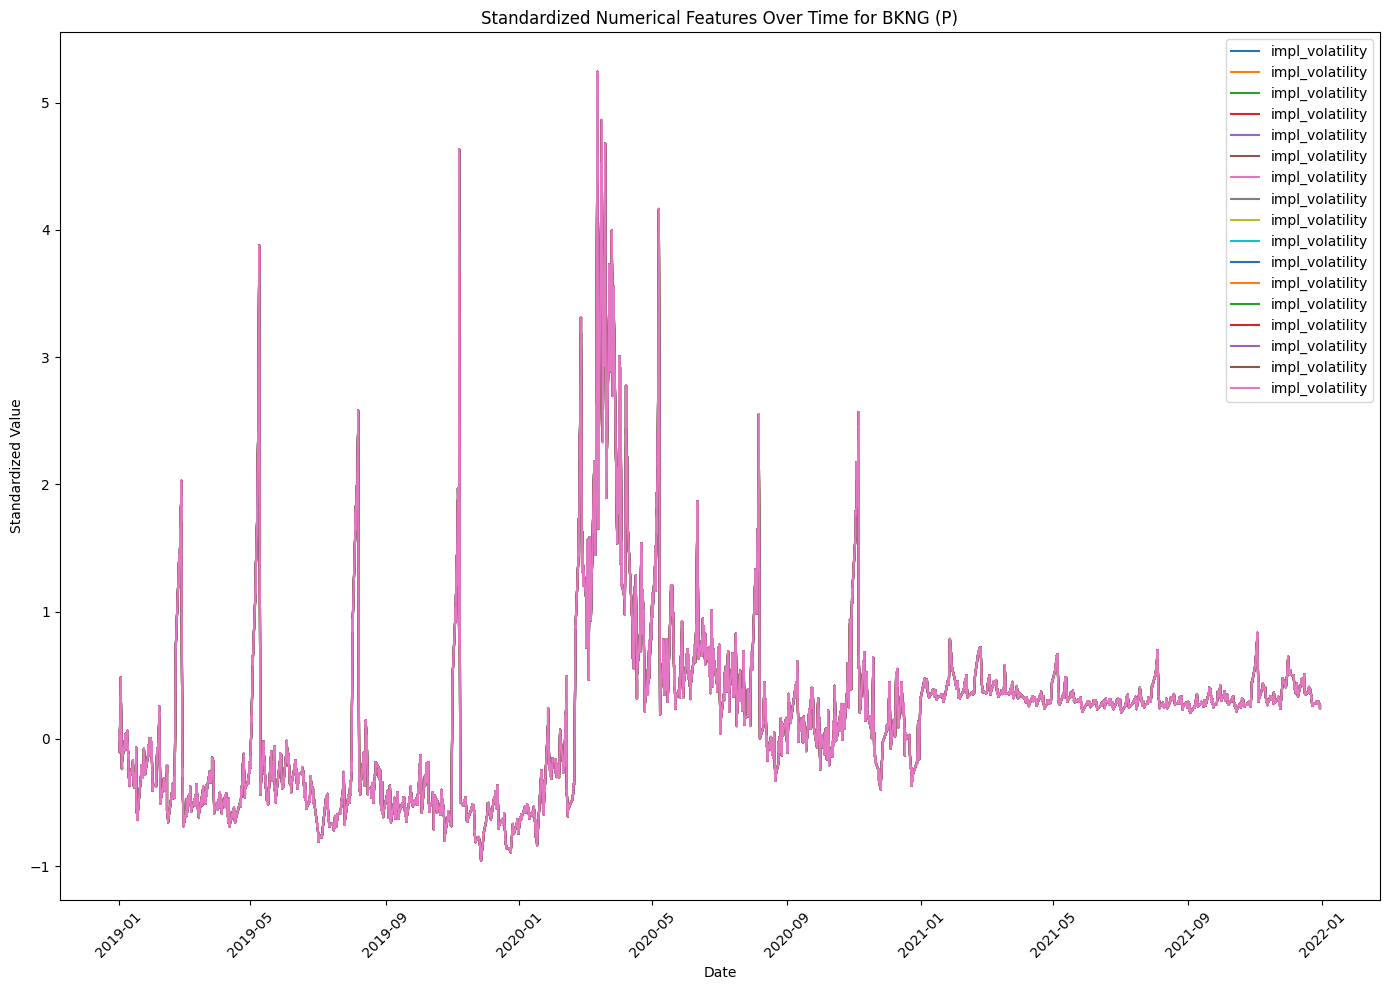

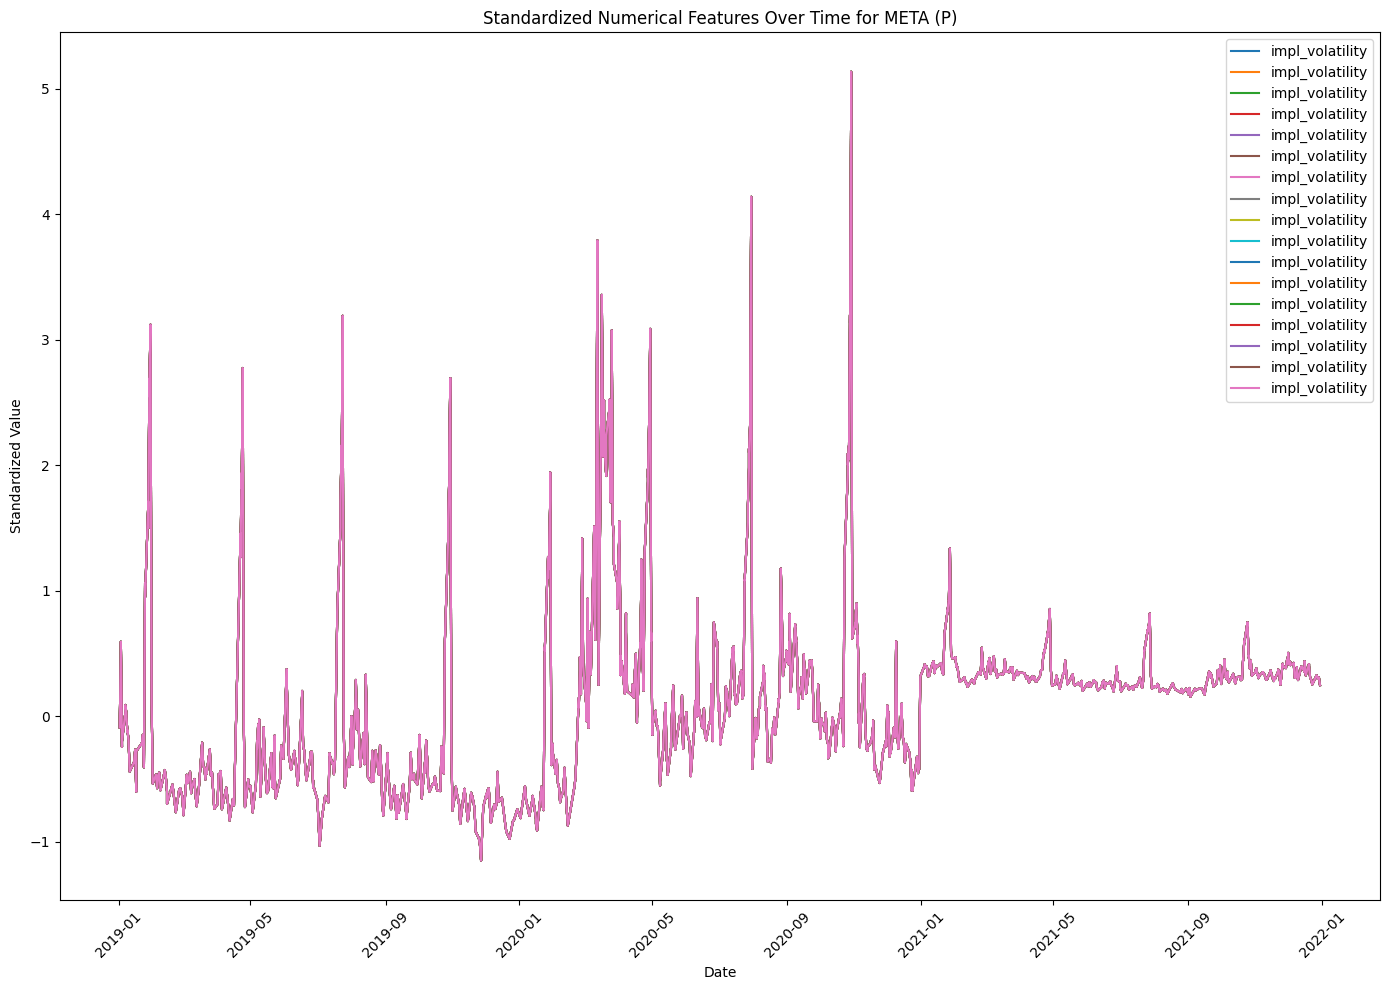

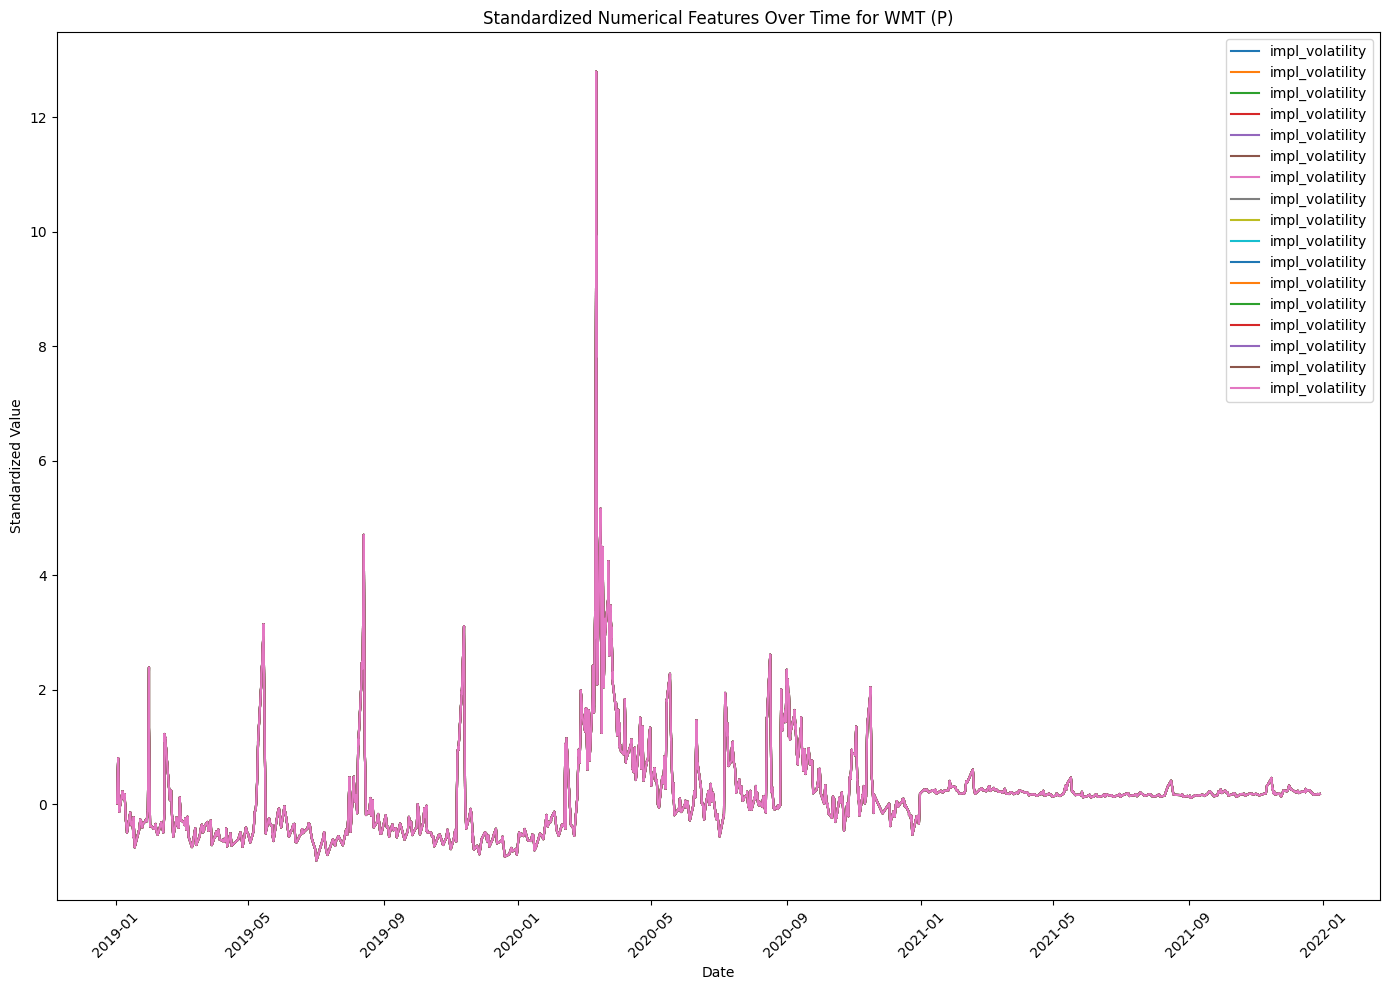

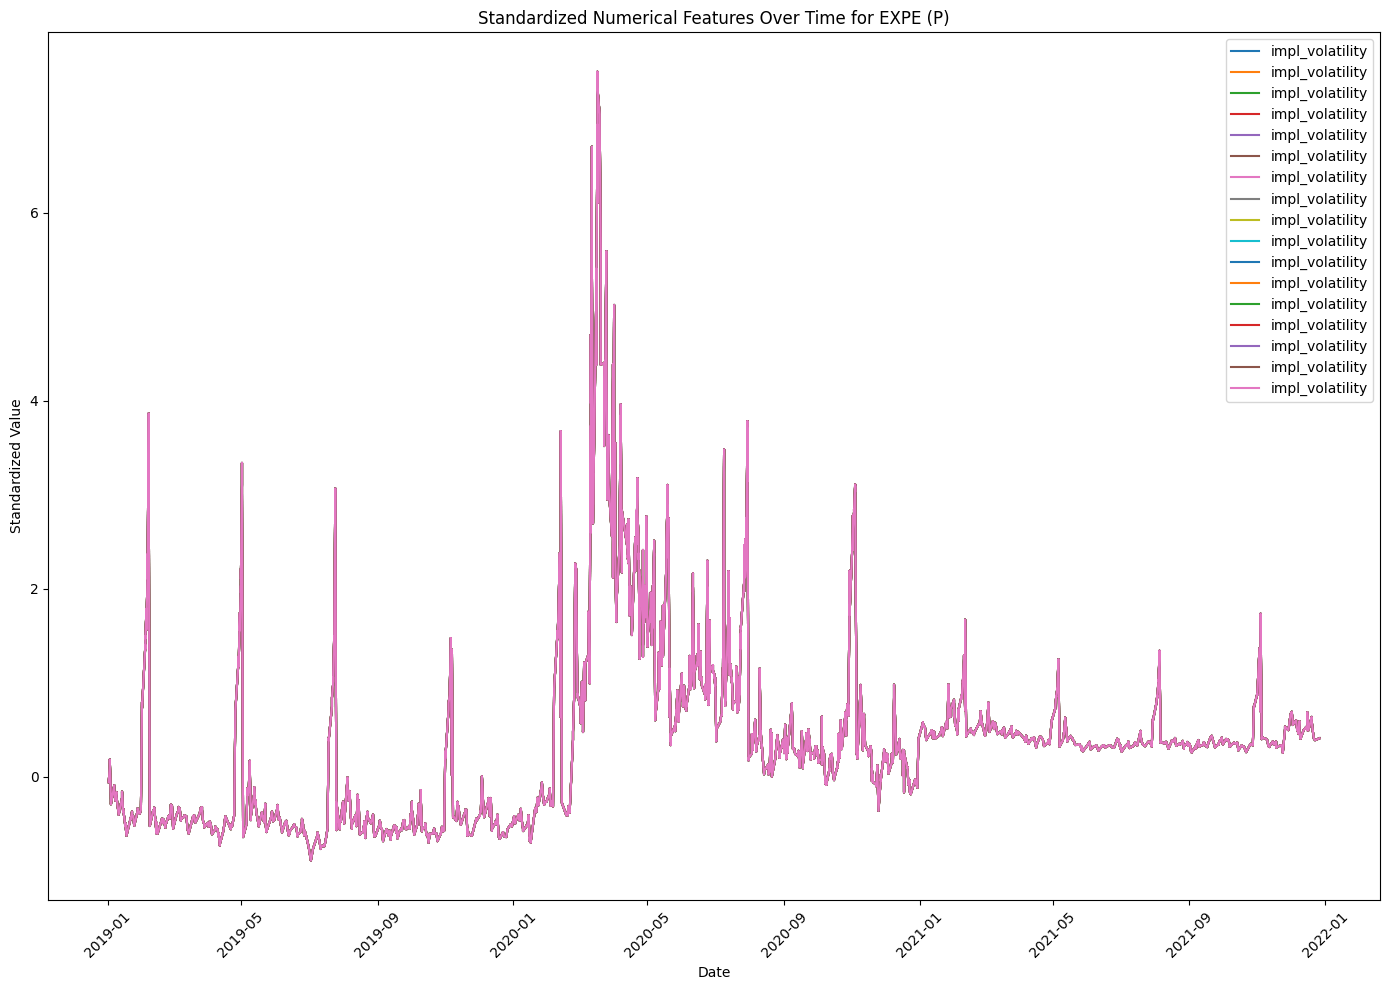

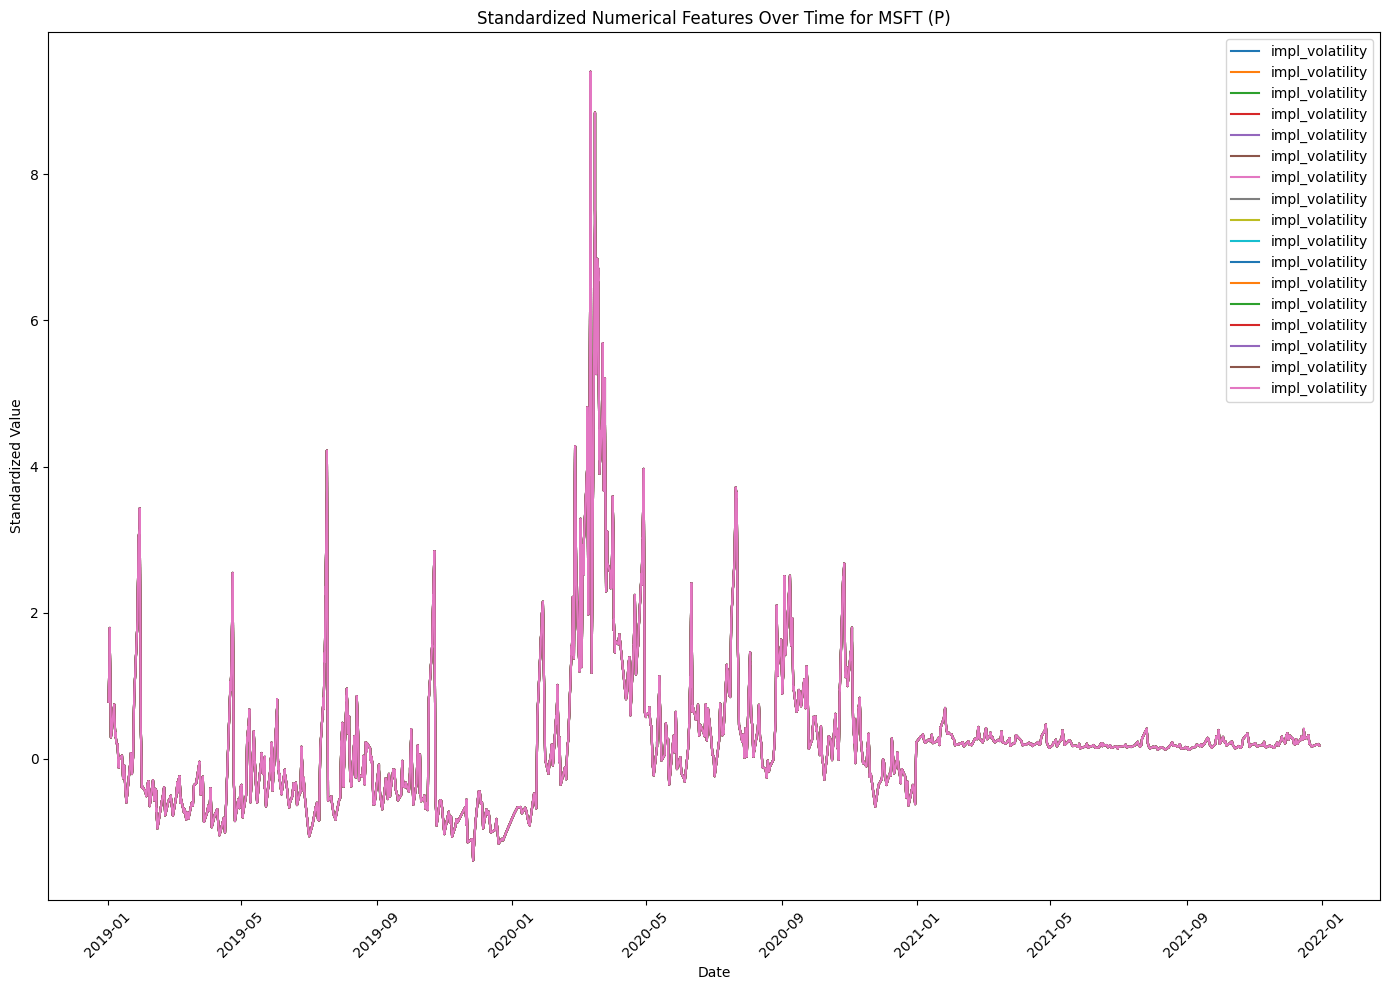

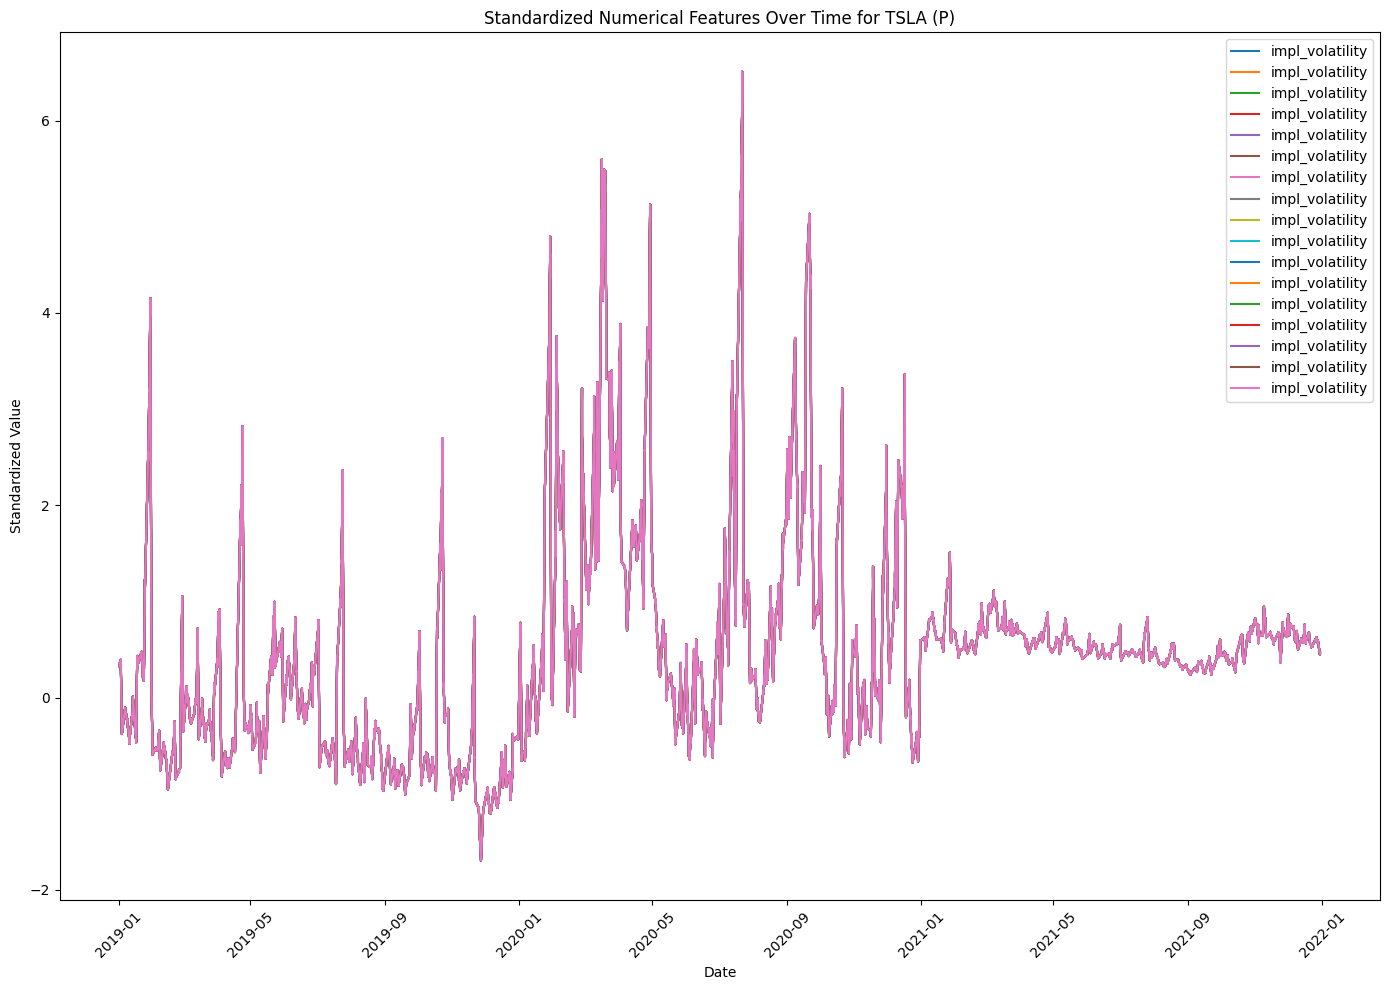

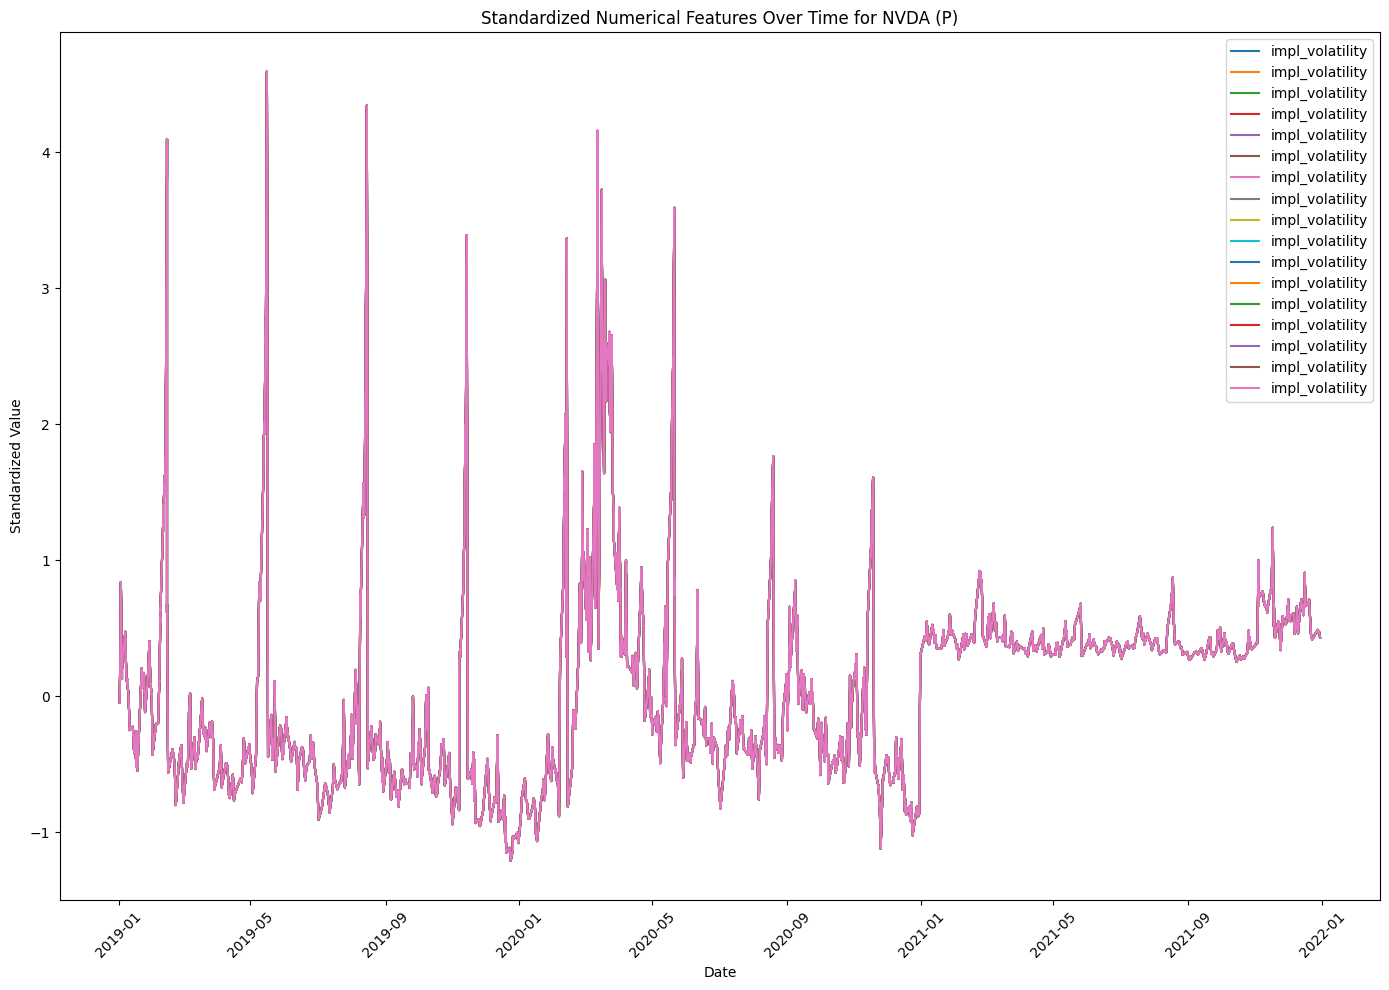

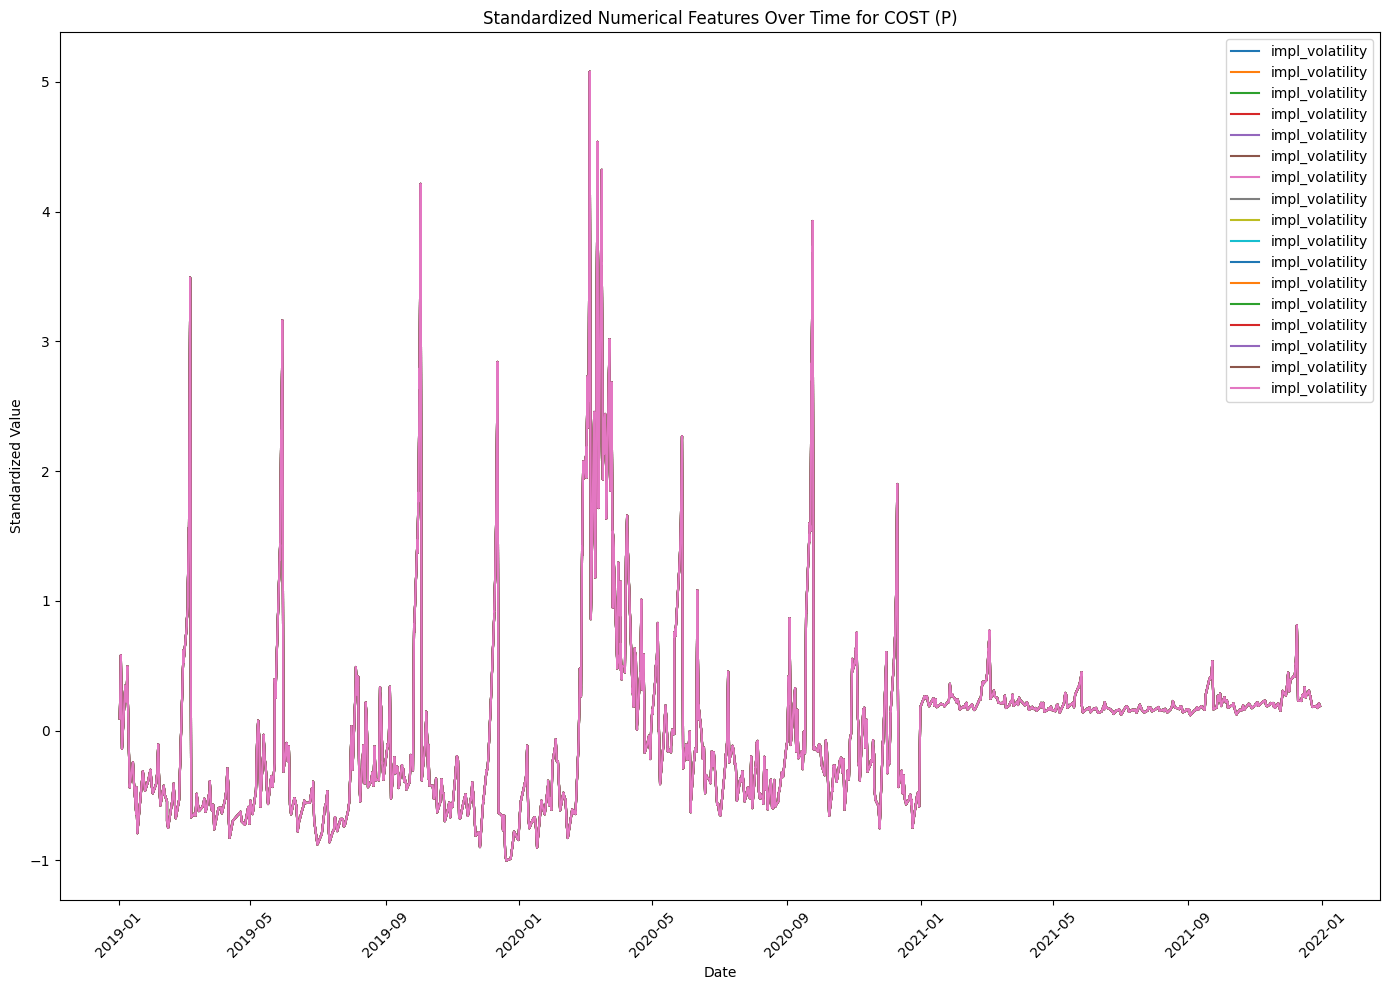

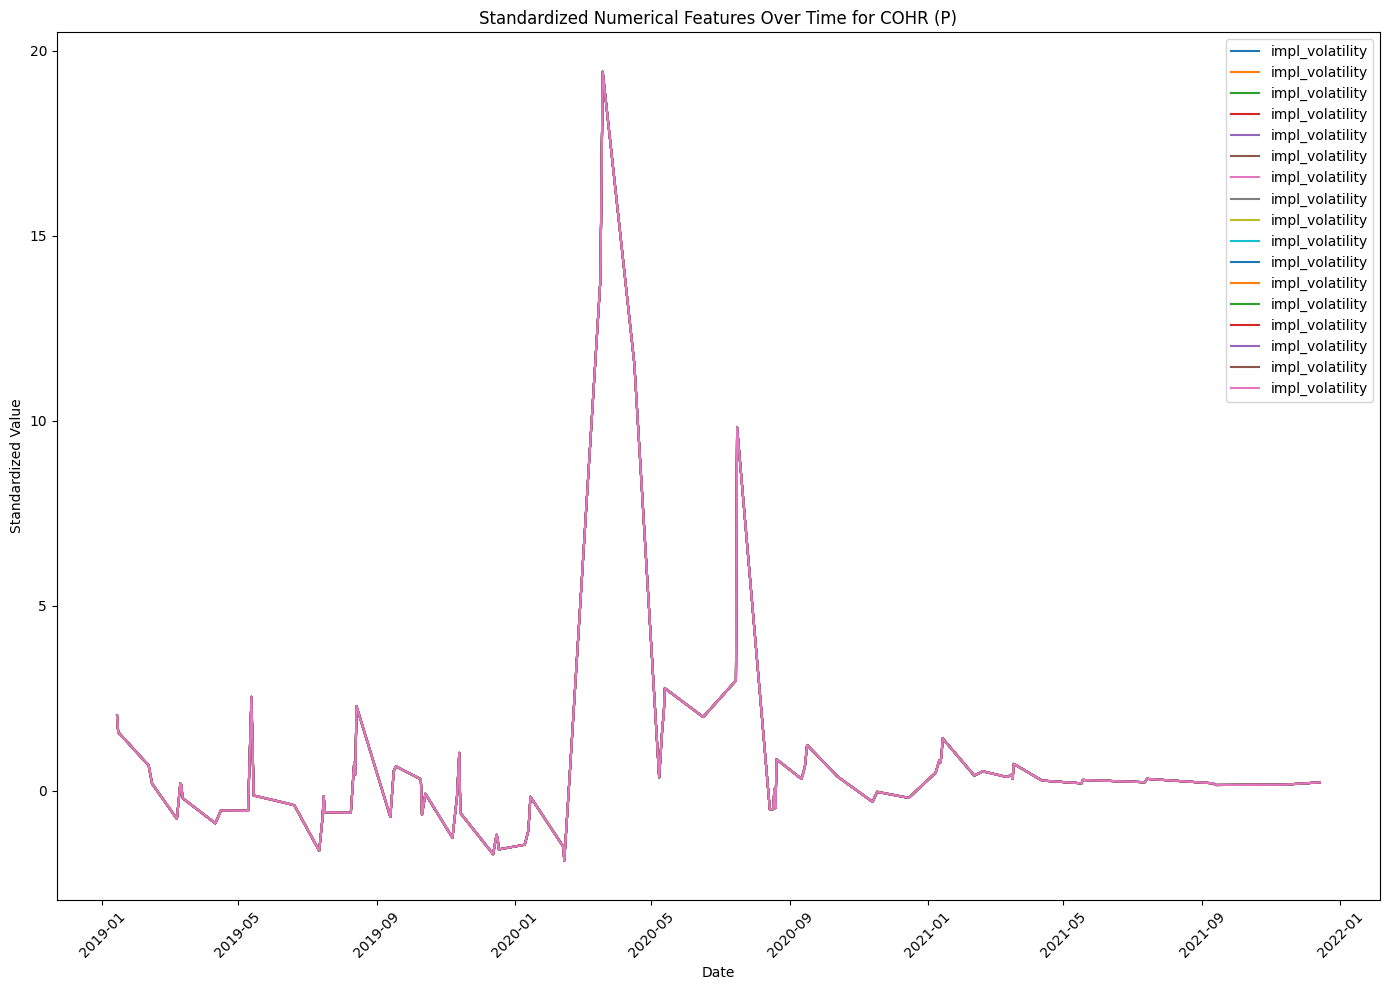

In [ ]:
# Get unique tickers
tickers = df_standardized['Ticker'].unique()

# Create a separate plot for each ticker
for ticker in tickers:
    # Select the rows for the current ticker where 'cp_flag' is 'P'
    df_ticker = df_standardized[(df_standardized['Ticker'] == ticker) & (df_standardized['cp_flag'] == 'C')]

    # If there are no rows for the current ticker with 'cp_flag' as 'P', skip to the next ticker
    if df_ticker.empty:
        continue

    # Create a new figure
    fig, ax = plt.subplots(figsize=(14, 10))

    # Plot each feature
    for feature in numerical_features:
        feature = "impl_volatility"
        ax.plot(df_ticker['date'], df_ticker[feature], label=feature)

    # Set the title and labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Standardized Value')
    ax.set_title(f'Standardized Numerical Features Over Time for {ticker} (P)')
    ax.legend()

    # Rotate the x-axis labels
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Display the DataFrame
    # import ace_tools as tools; tools.display_dataframe_to_user(name=f"Standardized DataFrame for {ticker} (P)", dataframe=df_ticker)

Means and standard deviations after standardization:
Permno: AMZN
Means:
strike_price             1.006498e+06
best_bid                 1.337952e+01
best_offer               1.379960e+01
volume                   6.377217e+02
open_interest            1.785696e+02
delta                   -2.645616e-02
gamma                   -4.042137e-01
vega                     3.869846e+01
theta                   -6.806559e+02
Prev_day_IV              2.862661e-01
PRC                      1.000907e+03
PRC_actual               5.304778e+01
impl_volatility          3.495073e-01
Annual_Dividend_Yield    0.000000e+00
2Y_bond                 -1.522725e+00
Forward_Price            1.000949e+03
atm_impl_volatility      3.383461e-01
dtype: float64
Standard Deviations:
strike_price             1.545024e+06
best_bid                 2.391272e+01
best_offer               2.462031e+01
volume                   2.531195e+03
open_interest            5.744573e+02
delta                    8.825806e-01
gamma            

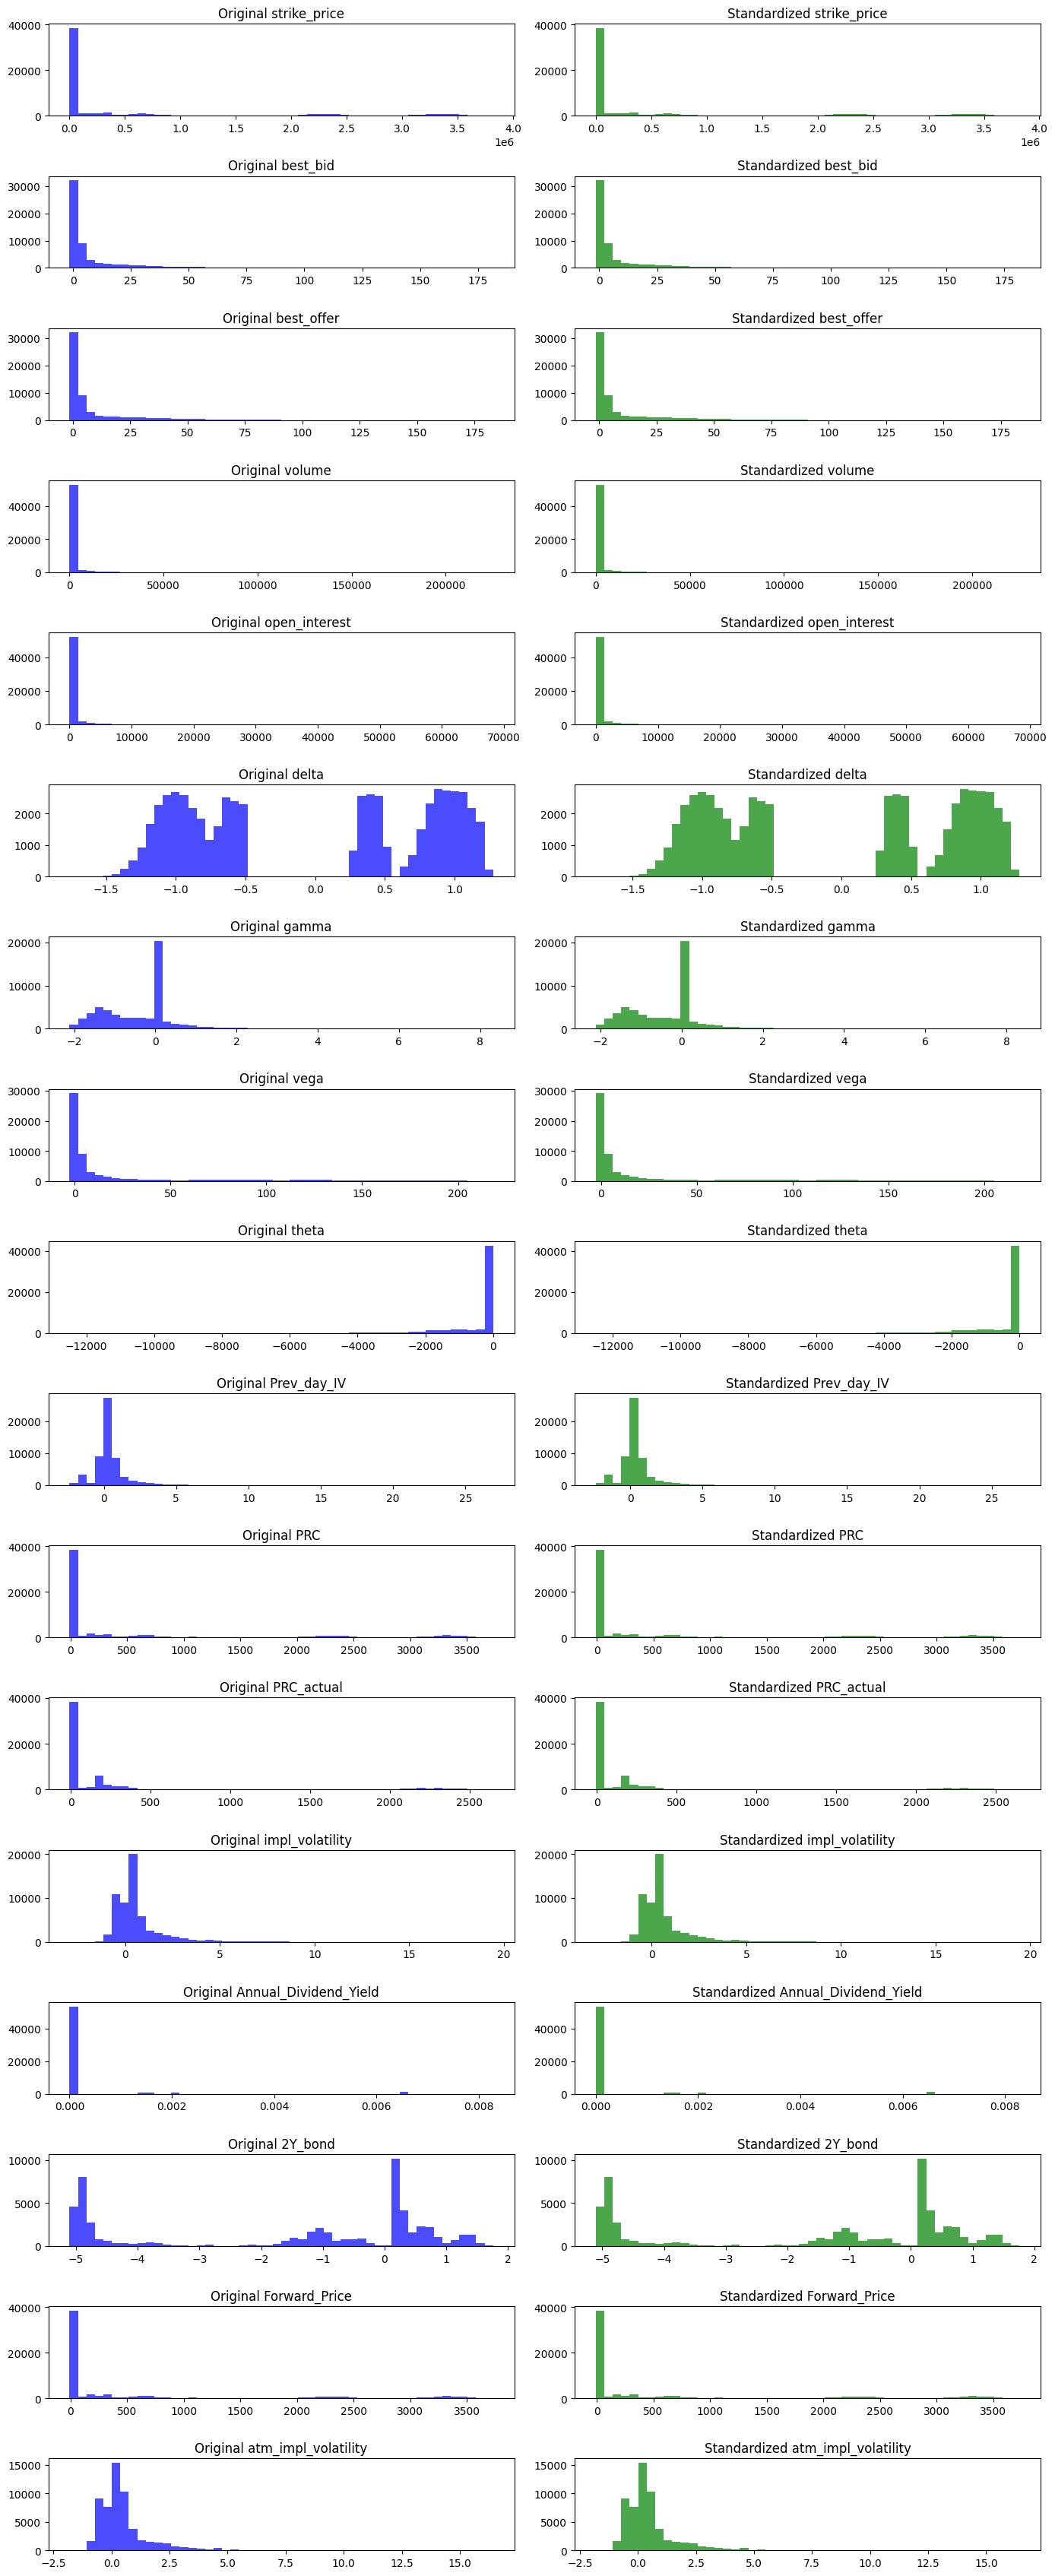

In [ ]:
# Check means and standard deviations
print("Means and standard deviations after standardization:")
for permno in df_standardized['Ticker'].unique():
    permno_data = df_standardized[df_standardized['Ticker'] == permno][numerical_features]
    means = permno_data.mean()
    stds = permno_data.std()
    print(f"Permno: {permno}")
    print("Means:")
    print(means)
    print("Standard Deviations:")
    print(stds)

# Plotting histograms before and after standardization for visual inspection
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(14, 2*len(numerical_features)))
for i, feature in enumerate(numerical_features):
    # Original data
    axes[i, 0].hist(df[feature], bins=50, color='blue', alpha=0.7)
    axes[i, 0].set_title(f"Original {feature}")
    
    # Standardized data
    axes[i, 1].hist(df_standardized[feature], bins=50, color='green', alpha=0.7)
    axes[i, 1].set_title(f"Standardized {feature}")

plt.tight_layout()
plt.show()

# import ace_tools as tools; tools.display_dataframe_to_user(name="Standardized DataFrame", dataframe=df_standardized)

In [ ]:
df_standardized

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category
3441,2019-01-02,2019-01-04,P,-2.394534e+00,0.048128,0.051704,-0.556636,-0.610924,0.748571,-0.804072,...,0.0,0.007937,2019-01-02,1.27978,-2.290612,0.507851,0.050266,1,τ ≤ 5,0 < m ≤ 0.5
3442,2019-01-02,2019-01-04,C,-2.394534e+00,-0.268720,-0.264386,-0.388431,-0.545414,0.564624,1.168038,...,0.0,0.007937,2019-01-02,1.27978,-2.290612,0.507851,0.050266,1,τ ≤ 5,0 < m ≤ 0.5
3443,2019-01-02,2019-01-04,P,-2.417696e+00,-0.036801,-0.056852,0.550309,-0.278806,0.727515,-0.768419,...,0.0,0.007937,2019-01-02,1.27978,-2.290612,0.507851,0.009196,1,τ ≤ 5,0 < m ≤ 0.5
3444,2019-01-02,2019-01-04,C,-2.417696e+00,-0.193591,-0.187758,1.599584,0.333631,0.562326,1.206924,...,0.0,0.007937,2019-01-02,1.27978,-2.290612,0.507851,0.009196,1,τ ≤ 5,0 < m ≤ 0.5
3704,2019-01-02,2019-01-04,C,-2.371373e+00,-0.343849,-0.341014,0.359677,-0.371738,0.561658,1.129153,...,0.0,0.007937,2019-01-02,1.27978,-2.290612,0.507851,0.091270,1,τ ≤ 5,0 < m ≤ 0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5307341,2021-12-30,2021-12-31,P,1.075000e+06,12.600000,13.300000,16670.000000,1473.000000,0.467151,-0.565470,...,0.0,0.003968,2021-12-30,0.80760,1070.374272,0.448418,0.152660,756,τ ≤ 5,0 < m ≤ 0.5
5307359,2021-12-30,2021-12-31,C,1.080000e+06,6.100000,6.200000,56094.000000,4315.000000,0.456935,0.358350,...,0.0,0.003968,2021-12-30,0.80760,1070.374272,0.448418,0.316935,756,τ ≤ 5,0 < m ≤ 0.5
5307360,2021-12-30,2021-12-31,P,1.080000e+06,16.000000,16.650000,27037.000000,4423.000000,0.482176,-0.634093,...,0.0,0.003968,2021-12-30,0.80760,1070.374272,0.448418,0.316935,756,τ ≤ 5,0 < m ≤ 0.5
5307361,2021-12-30,2021-12-31,C,1.085000e+06,4.800000,5.000000,18981.000000,2890.000000,0.473730,0.296189,...,0.0,0.003968,2021-12-30,0.80760,1070.374272,0.448418,0.480451,756,τ ≤ 5,0 < m ≤ 0.5


In [ ]:
print(data.columns)

Index(['date', 'exdate', 'cp_flag', 'strike_price', 'best_bid', 'best_offer',
       'volume', 'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega',
       'theta', 'Ticker', 'Prev_day_IV', 'trading_days_till_exp', 'PRC',
       'PRC_actual', 'Year', 'Annual_Dividend_Yield', 'T', 'DATE', '2Y_bond',
       'Forward_Price', 'atm_impl_volatility', 'moneyness', 'trading_day',
       'maturity_group', 'm_category'],
      dtype='object')
